# The Impact of Litigations on GHG Emissions
* "litigation" from [Graham Institute](https://climate-laws.org/legislation_and_policies), takes the value of 1 when the first case related to environmental laws was solved in a given year, independently of the result
* "rule of law" from World Bank
* Sample excludes the US, and includes all countries for which there has been at least a case with a resolution: 23 countries, mostly HI and MI countries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('litigation.csv')

Define Country_ID as numerical

In [3]:
df['id'] = df.groupby('country').ngroup()

Creation of log values

In [4]:
df['lnghg'] = np.log(df['ghg'])
df['lngdp'] = np.log(df['gdp'])
df['lngdp2'] = df['lngdp']**2
df['lnpopulation'] = np.log(df['population'])
df['lnlaw'] = np.log(df['ruleoflaw'])

Definition of High-Income and Middle-Income countries

In [5]:
hi_countries = ['BEL', 'AUS', 'CAN', 'CHE', 'DEU', 'ESP', 'EST', 'FIN', 
                'FRA', 'GBR', 'GRC', 'HRV', 'ITA', 'LTU', 'LUX', 'NLD', 
                'NOR', 'NZL', 'POL', 'PRT', 'SVK', 'SWE', 'ROU']
df['HI'] = 0
df.loc[df['country'].isin(hi_countries), 'HI'] = 1

In [6]:
mi_countries = ['BGR', 'CRI', 'FJI', 'IND', 'KEN', 
                'PAK', 'NPL', 'PHL', 'UKR']
df['MI'] = 0
df.loc[df['country'].isin(mi_countries), 'MI'] = 1

### Figure 3. GHG Evolution of Emissions over Time. Whole Sample

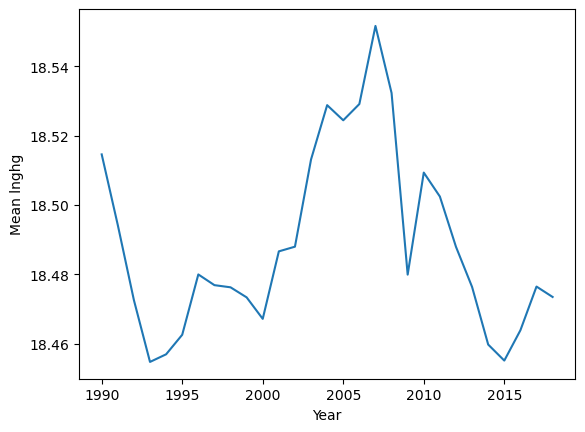

In [7]:
collapsed_data = df.groupby('year')['lnghg'].mean().reset_index()
plt.plot(collapsed_data['year'], collapsed_data['lnghg']);
plt.xlabel('Year');
plt.ylabel('Mean lnghg');

### Figure 4. GHG Evolution of Emissions over Time. High-Income Countries

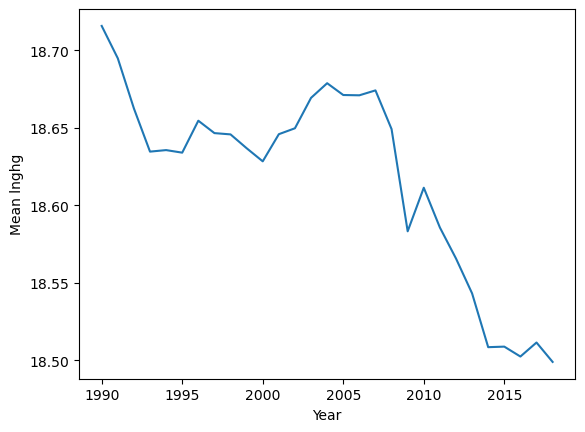

In [8]:
filtered_data = df[df['HI'] == 1]
collapsed_data = filtered_data.groupby('year')['lnghg'].mean().reset_index()
plt.plot(collapsed_data['year'], collapsed_data['lnghg']);
plt.xlabel('Year');
plt.ylabel('Mean lnghg');

###  Figure 5. GHG Evolution of Emissions over Time. Middle-Income Countries

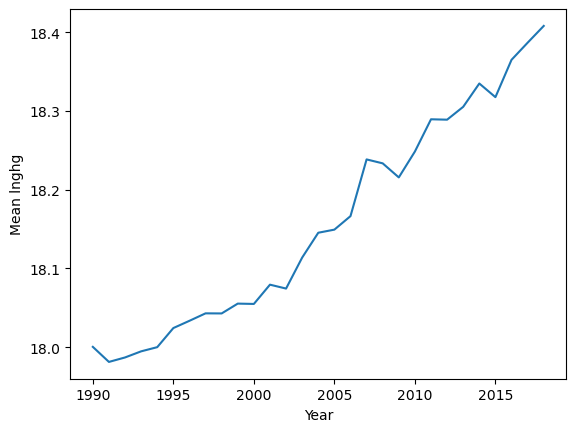

In [9]:
filtered_data = df[df['MI'] == 1]
collapsed_data = filtered_data.groupby('year')['lnghg'].mean().reset_index()
plt.plot(collapsed_data['year'], collapsed_data['lnghg']);
plt.xlabel('Year');
plt.ylabel('Mean lnghg');

### Table 2. Summary statistics

Panel A: Whole sample

In [10]:
df[['ghg', 'gdp', 'population', 'ruleoflaw']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ghg,928.0,2.746628e+08,4.261440e+08,1.820000e+06,4.594000e+07,8.563000e+07,4.101825e+08,3.374990e+09
gdp,905.0,3.090654e+04,2.202428e+04,1.616649e+03,1.233693e+04,3.042260e+04,4.334579e+04,1.206478e+05
population,928.0,6.249544e+07,1.953776e+08,3.818500e+05,5.102926e+06,1.318928e+07,4.649039e+07,1.352642e+09
ruleoflaw,640.0,7.181731e+01,2.538809e+01,1.435644e+01,5.406699e+01,7.884616e+01,9.487048e+01,1.000000e+02


Panel B: High-income countries

In [11]:
df[df['HI'] == 1][['ghg', 'gdp', 'population', 'ruleoflaw']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ghg,667.0,2.449091e+08,2.650918e+08,8.480000e+06,4.956500e+07,1.058500e+08,4.335200e+08,1.160210e+09
gdp,644.0,4.009267e+04,1.906390e+04,1.048390e+04,2.831599e+04,3.821160e+04,4.688971e+04,1.206478e+05
population,667.0,2.227225e+07,2.326177e+07,3.818500e+05,4.969760e+06,1.051484e+07,3.805298e+07,8.290578e+07
ruleoflaw,460.0,8.428275e+01,1.553785e+01,1.435644e+01,7.319880e+01,9.014085e+01,9.618132e+01,1.000000e+02


Panel C: Middle-income countries

In [12]:
df[df['MI'] == 1][['ghg', 'gdp', 'population', 'ruleoflaw']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ghg,261.0,3.506999e+08,6.777799e+08,1.820000e+06,2.705000e+07,6.708000e+07,3.068600e+08,3.374990e+09
gdp,261.0,8.240378e+03,7.937578e+03,1.616649e+03,3.315814e+03,5.606591e+03,1.142933e+04,7.632330e+04
population,261.0,1.652880e+08,3.463463e+08,7.285750e+05,7.348328e+06,3.563527e+07,9.557005e+07,1.352642e+09
ruleoflaw,180.0,3.996117e+01,1.618883e+01,1.435644e+01,2.484840e+01,3.804979e+01,5.306624e+01,7.400000e+01


#### Summaries of log variables

Panel A: Whole sample

In [13]:
df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 'litigation']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lnghg,928.0,18.488506,1.495460,14.414347,17.642847,18.265493,19.832111,21.939658
lngdp,905.0,9.986052,0.975039,7.388111,9.420352,10.322941,10.676965,11.700631
lngdp2,905.0,100.670888,18.650197,54.584184,88.743036,106.563113,113.997577,136.904766
lnpopulation,928.0,16.523040,1.576204,12.852783,15.445323,16.385909,17.654756,21.025326
lnlaw,640.0,4.183953,0.470828,2.664199,3.990224,4.367480,4.552512,4.605170
litigation,928.0,0.217672,0.412886,0.000000,0.000000,0.000000,0.000000,1.000000


Panel B: High-income countries

In [14]:
df[df['HI'] == 1][['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
                   'lnlaw', 'litigation']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lnghg,667.0,18.617904,1.272050,15.953221,17.718795,18.477534,19.887445,20.871867
lngdp,644.0,10.494968,0.464056,9.257596,10.251182,10.550894,10.755553,11.700631
lngdp2,644.0,110.359366,9.684836,85.703087,105.086732,111.321371,115.681914,136.904766
lnpopulation,667.0,16.261457,1.283457,12.852783,15.418876,16.168299,17.454490,18.233215
lnlaw,460.0,4.411902,0.230541,2.664199,4.293179,4.501373,4.566235,4.605170
litigation,667.0,0.259370,0.438618,0.000000,0.000000,0.000000,1.000000,1.000000


Panel C: Middle-income countries

In [15]:
df[df['MI'] == 1][['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
                   'lnlaw', 'litigation']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
lnghg,261.0,18.157824,1.917304,14.414347,17.113198,18.021396,19.541902,21.939658
lngdp,261.0,8.730336,0.740639,7.388111,8.106459,8.631698,9.343938,11.242734
lngdp2,261.0,76.765218,13.085615,54.584184,65.714670,74.506212,87.309185,126.399059
lnpopulation,261.0,17.191531,2.003558,13.498846,15.809983,17.388846,18.375370,21.025326
lnlaw,180.0,3.601417,0.424611,2.664199,3.212791,3.638894,3.971541,4.304065
litigation,261.0,0.111111,0.314873,0.000000,0.000000,0.000000,0.000000,1.000000


### Table 3. Estimation Results for the Whole Sample

(1) OLS

In [16]:
# reg lnghg lngdp lngdp2 lnpopulation lnlaw litigation , robust
import statsmodels.api as sm

data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation']].dropna()
X = data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 'litigation']]
X = sm.add_constant(X)
y = data['lnghg']
model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnghg   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     1892.
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:47:54   Log-Likelihood:                -346.41
No. Observations:                 639   AIC:                             704.8
Df Residuals:                     633   BIC:                             731.6
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -14.2282      1.462     -9.730   

(2) TW-FE

In [17]:
# xtreg lnghg lngdp lngdp2 lnpopulation lnlaw litigation i.year, fe robust
from linearmodels.panel import PanelOLS

data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'year', 'id']].dropna()
data['cons'] = 1
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 'litigation', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7140
Estimator:                   PanelOLS   R-squared (Between):              0.6795
No. Observations:                 639   R-squared (Within):              -0.2175
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.6722
Time:                        13:47:54   Log-likelihood                    823.42
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      291.14
Entities:                          32   P-value                           0.0000
Avg Obs:                       19.969   Distribution:                   F(5,583)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             1559.3
                            

(3) OLS

In [18]:
# reg lnghg lngdp lngdp2 lnpopulation lnlaw HI#c.litigation, robust
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'year', 'id', 'HI']].dropna()
data['HITRUE_litigation'] = data['HI'] * data['litigation']
data['HIFALSE_litigation'] = (1-data['HI']) * data['litigation']

X = data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 
          'HIFALSE_litigation', 'HITRUE_litigation']]
X = sm.add_constant(X)
y = data['lnghg']

model = sm.OLS(y, X).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  lnghg   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1607.
Date:                Fri, 15 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:47:54   Log-Likelihood:                -344.84
No. Observations:                 639   AIC:                             703.7
Df Residuals:                     632   BIC:                             734.9
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -13.9922      1

(4) TW-FE

In [19]:
# xtreg lnghg lngdp lngdp2 lnpopulation lnlaw HI#c.litigation i.year, fe robust
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'year', 'id', 'HI']].dropna()
data['cons'] = 1
data['HITRUE_litigation'] = data['HI'] * data['litigation']
data['HIFALSE_litigation'] = (1-data['HI']) * data['litigation']
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 
                'HIFALSE_litigation', 'HITRUE_litigation', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7152
Estimator:                   PanelOLS   R-squared (Between):              0.6746
No. Observations:                 639   R-squared (Within):              -0.2016
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.6675
Time:                        13:47:55   Log-likelihood                    824.70
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      243.57
Entities:                          32   P-value                           0.0000
Avg Obs:                       19.969   Distribution:                   F(6,582)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             1346.9
                            

### Table 4. Results with interactions and Instrumental Variables

(1) Interaction

In [20]:
# xtreg lnghg lngdp lngdp2 lnpop c.lnlaw#i.litigation i.year, fe robust
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'year', 'id']].dropna()
data['cons'] = 1
data['lnlaw_litigation'] = data['lnlaw'] * data['litigation']
data['lnlaw_no_litigation'] = data['lnlaw'] * (1 - data['litigation'])
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 
                'lnlaw_no_litigation', 'lnlaw_litigation', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
#results = model.fit(cov_type='kernel', kernel='bartlett')
results = model.fit(cov_type='robust')

print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7143
Estimator:                   PanelOLS   R-squared (Between):              0.6758
No. Observations:                 639   R-squared (Within):              -0.2162
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.6686
Time:                        13:47:55   Log-likelihood                    823.76
Cov. Estimator:                Robust                                           
                                        F-statistic:                      291.58
Entities:                          32   P-value                           0.0000
Avg Obs:                       19.969   Distribution:                   F(5,583)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             254.24
                            

(2) UMI

In [21]:
# gen UMI=0
# quietly replace UMI=1 if gdp<12700
df['UMI'] = 0
df.loc[df['gdp']<12700, 'UMI'] = 1

In [22]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw UMI#c.litigation i.year, fe  robust
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'year', 'id', 'UMI']].dropna()
data['cons'] = 1
data['UMITRUE_litigation'] = data['UMI'] * data['litigation']
data['UMIFALSE_litigation'] = (1-data['UMI']) * data['litigation']
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 
                'UMIFALSE_litigation', 'UMITRUE_litigation', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7141
Estimator:                   PanelOLS   R-squared (Between):              0.6782
No. Observations:                 639   R-squared (Within):              -0.2209
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.6710
Time:                        13:47:55   Log-likelihood                    823.49
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      242.28
Entities:                          32   P-value                           0.0000
Avg Obs:                       19.969   Distribution:                   F(6,582)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             2276.3
                            

(3) IV-GMM

In [23]:
# xi:xtivreg2 lnghg lngdp lngdp2 lnpop lnlaw i.year (litigation=l(-2/-1).fillingdate), fe gmm
from linearmodels.iv import IV2SLS

formula = 'lnghg ~ 1 + lngdp + lngdp2 + lnpopulation + lnlaw + [litigation ~ fillingdate_lag1 + fillingdate_lag2]'
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'year', 'id', 'fillingdate']].dropna()
data['fillingdate_lag1'] = data['fillingdate'].shift(1)
data['fillingdate_lag2'] = data['fillingdate'].shift(2)

panel_data = data.dropna().set_index(['id', 'year'])

iv_model = IV2SLS.from_formula(formula, panel_data)
iv_results = iv_model.fit()

print(iv_results)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lnghg   R-squared:                      0.9224
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9218
No. Observations:                 636   F-statistic:                    9736.0
Date:                Fri, Mar 15 2024   P-value (F-stat)                0.0000
Time:                        13:47:55   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept       -14.138     1.4494    -9.7546     0.0000     -16.979     -11.297
lngdp            2.5542     0.3055     8.361

### Table 5. Results without EIT, for EU Countries and by Type of Litigation Decision

(1) EIT-FE

In [24]:
# gen EIT=1
# local non_EIT_countries "BGR HRV EST LTU POL ROU SVK"
# foreach country of local non_EIT_countries {
#     quietly replace EIT = 0 if country == "`country'"
# }
non_EIT_countries = ['BGR', 'HRV', 'EST', 'LTU',
                     'POL', 'ROU', 'SVK']
df['EIT'] = 1
df.loc[df['country'].isin(non_EIT_countries), 'EIT'] = 0

In [25]:
#xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation i.year if EIT==1,fe robust
data = df[df['EIT'] == 1][['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
                           'lnlaw', 'litigation', 'year', 'id']].dropna()
data['cons'] = 1
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 'litigation', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7624
Estimator:                   PanelOLS   R-squared (Between):              0.5864
No. Observations:                 499   R-squared (Within):              -0.1304
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.5801
Time:                        13:47:55   Log-likelihood                    653.51
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      288.71
Entities:                          25   P-value                           0.0000
Avg Obs:                       19.960   Distribution:                   F(5,450)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             2528.5
                            

(2) EU-FE

In [26]:
# gen EU=1
# local non_EU_countries "CAN CRI FJI IND KEN NZL PAK PHL AUS NPL"
# foreach country of local non_EU_countries {
#     quietly replace EU = 0 if country == "`country'"
# }
non_EU_countries = ['CAN', 'CRI', 'FJI', 'IND', 'KEN',
                    'NZL', 'PAK', 'PHL', 'AUS', 'NPL']
df['EU'] = 1
df.loc[df['country'].isin(non_EU_countries), 'EU'] = 0

In [27]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation i.year if EU==1,fe robust
data = df[df['EU'] == 1][['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
                           'lnlaw', 'litigation', 'year', 'id']].dropna()
data['cons'] = 1
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 'litigation', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.3013
Estimator:                   PanelOLS   R-squared (Between):              0.5663
No. Observations:                 440   R-squared (Within):              -0.4633
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.5586
Time:                        13:47:55   Log-likelihood                    631.44
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      33.977
Entities:                          22   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                   F(5,394)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             266.73
                            

(3) By litigation decision type

In [28]:
# gen ncl=0  
# local ncl_countries "AUS BEL EST DEU GRC NZL NOR GBR CHE UKR PTR KEN FJI"
# foreach country of local ncl_countries {
#     quietly replace ncl = 1 if country == "`country'"
# }
# gen ncllitig=ncl*litigation
ncl_countries = ['AUS', 'BEL', 'EST', 'DEU',
                 'GRC', 'NZL', 'NOR', 'GBR',
                 'CHE', 'UKR', 'PTR', 'KEN', 'FJI']
df['ncl'] = 0
df.loc[df['country'].isin(ncl_countries), 'ncl'] = 1
df['ncllitig'] = df['ncl'] * df['litigation']

In [29]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation ncllitig i.year,fe robust
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'ncllitig', 'year', 'id']].dropna()
data['cons'] = 1
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 
                'litigation', 'ncllitig', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7143
Estimator:                   PanelOLS   R-squared (Between):              0.6787
No. Observations:                 639   R-squared (Within):              -0.2275
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.6713
Time:                        13:47:55   Log-likelihood                    823.66
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      242.47
Entities:                          32   P-value                           0.0000
Avg Obs:                       19.969   Distribution:                   F(6,582)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             1509.5
                            

(4) Kyoto

In [30]:
# gen kyoto=0
# quietly replace kyoto=1 if HI==1&year>=2008
df['kyoto'] = 0
df.loc[df['HI'] * df['year']>=2008, 'kyoto'] = 1

In [31]:
# xtreg lnghg lngdp lngdp2 lnpop lnlaw litigation  kyoto i.year,fe robust
data = df[['lnghg', 'lngdp', 'lngdp2', 'lnpopulation', 
           'lnlaw', 'litigation', 'kyoto', 'year', 'id']].dropna()
data['cons'] = 1
panel_data = data.set_index(['id', 'year'])

y = panel_data['lnghg']
X = panel_data[['lngdp', 'lngdp2', 'lnpopulation', 'lnlaw', 
                'litigation', 'kyoto', 'cons']]

model = PanelOLS(y, X, entity_effects=True, time_effects=True)
results = model.fit(cov_type='kernel', kernel='bartlett')
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lnghg   R-squared:                        0.7204
Estimator:                   PanelOLS   R-squared (Between):              0.6963
No. Observations:                 639   R-squared (Within):               0.0771
Date:                Fri, Mar 15 2024   R-squared (Overall):              0.6912
Time:                        13:47:55   Log-likelihood                    830.55
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      249.86
Entities:                          32   P-value                           0.0000
Avg Obs:                       19.969   Distribution:                   F(6,582)
Min Obs:                       19.000                                           
Max Obs:                       20.000   F-statistic (robust):             1365.7
                            